# Meta-Learning


Here we investigate using optax to meta-learn the learning rate of an optax optimizer. For a concrete example, we define a model where $y$ is linearly related to $x$, with some added noise,

$$y = f(x) = 10 \cdot x + \mathcal{N}(0, 1).$$

We imagine trying to solve the problem where we have access to some data generated by $f(\cdot)$, but we do not know what $f$ actually is. Thus, we can attempt to  approximate $f(\cdot)$ using a parametrized function, $f(\theta, x).$ We can find a good value of $\theta$ using gradient descent with optax. 

Gradient descent typically requires hyper-parameters be chosen, for example the learning rate of the optimizer. Using meta-learning, we are able to simultaneously optimize over parameters of our optimizer, whilst also optimizing over the underlying parameters for the function we are fitting.

Many meta-learning algorithms now take the following form,

1. An inner loop performs $N$ updates to a model's parameters $\theta$ using the current value of a hyper-parameter $\eta$.
1. An outer loop updates the hyper-parameter $\eta$ to maximize the quality of the inner updates to $\theta$ by differentiating through the inner updates.

Since in our case we are interested in the learning rate, which is
bounded between 0 and 1, we parametrize the learning rate as a sigmoid
over the meta parameter $\eta$.

In the following snippts, we will solve the problem using optax. To begin with, we define a generator that samples from the hidden underlying distribution.

In [10]:
from typing import Callable, Iterator, Tuple
import chex
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax

In [11]:
def generator() -> Iterator[Tuple[chex.Array, chex.Array]]:
  rng = jax.random.PRNGKey(0)

  while True:
    rng, k1, k2 = jax.random.split(rng, num=3)
    x = jax.random.uniform(k1, minval=0.0, maxval=10.0)
    y = 10.0 * x + jax.random.normal(k2)
    yield x, y

We demonstrate sampling from this as follows,

In [12]:
g = generator()

for _ in range(5):
  x, y = next(g)
  print(f"Sampled y = {y:.3f}, x = {x:.3f}")

Sampled y = 72.695, x = 7.184
Sampled y = 3.827, x = 0.367
Sampled y = 3.362, x = 0.327
Sampled y = 10.027, x = 0.973
Sampled y = 96.446, x = 9.739


We now define our parametrized function $f(\theta, x)$, and choose a random initial value for the parameter $\theta$.

In [13]:
def f(theta: chex.Array, x: chex.Array) -> chex.Array:
  return x * theta

theta = jax.random.normal(jax.random.PRNGKey(42))

For the internal optimizer, which will fit $\theta$, we will use RMSProp. For the external optimizer, which we will use to fit the learning rate, we will use Adam. In optax, we must use `optax.inject_hyperparams` in order to allow the outer optimizer to modify the learning rate of the inner optimizer.

The inner optimizer is initialized with a learning rate of 0.1, and the outer optimizer is initialized with a learning rate of 0.03.

In [14]:
init_learning_rate = jnp.array(0.1)
meta_learning_rate = jnp.array(0.03)

opt = optax.inject_hyperparams(optax.rmsprop)(learning_rate=init_learning_rate)
meta_opt = optax.adam(learning_rate=meta_learning_rate)

In the following code, we implement a step of gradient descent using the computed loss.

In [21]:
def loss(theta, x, y):
  return optax.l2_loss(y, f(theta, x))


def step(theta, state, x, y):
  grad = jax.grad(loss)(theta, x, y)
  updates, state = opt.update(grad, state)
  theta = optax.apply_updates(theta, updates)
  return theta, state
x, y = next(g)
print(loss(theta, x, y))

0.0013195684


For the meta-learning part of the problem, we will use the inner step to compute an _outer_ loss value, and an _outer_ step.

These look very similar to the inner step, however, this outer step will inject the value of the learning rate hyperparameter into the state for the inner optimizer.

We use `jax.jit` on the outer step of our computation, to use JAX to optimize our computation.

In [22]:
@jax.jit
def outer_loss(eta, theta, state, samples):
  state.hyperparams['learning_rate'] = jax.nn.sigmoid(eta)

  for x, y in samples[:-1]:
    theta, state = step(theta, state, x, y)

  x, y = samples[-1]

  return loss(theta, x, y), (theta, state)


@jax.jit
def outer_step(eta, theta, meta_state, state, samples):
  grad, (theta, state) = jax.grad(
      outer_loss, has_aux=True)(eta, theta, state, samples)

  meta_updates, meta_state = meta_opt.update(grad, meta_state)
  eta = optax.apply_updates(eta, meta_updates)

  return eta, theta, meta_state, state

In the following, we put all of the code above together in order to fit a value for $\theta$.

In [23]:
state = opt.init(theta)
# inverse sigmoid, to match the value we initialized the inner optimizer with.
eta = -np.log(1. / init_learning_rate - 1)
meta_state = meta_opt.init(eta)

N = 7
learning_rates = []
thetas = []

for i in range(2000):
  samples = [next(g) for i in range(N)]
  eta, theta, meta_state, state = outer_step(eta, theta, meta_state, state, samples)
  learning_rates.append(jax.nn.sigmoid(eta))
  thetas.append(theta)

We can now plot the learning rates and values for $\theta$ that we computed during our optimization,

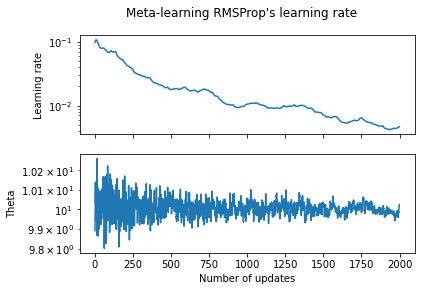

In [24]:
fig, (ax1, ax2) = plt.subplots(2);
fig.suptitle('Meta-learning RMSProp\'s learning rate');
plt.xlabel('Step');

ax1.semilogy(range(len(learning_rates)), learning_rates);
ax1.set(ylabel='Learning rate');
ax1.label_outer();

plt.xlabel('Number of updates');
ax2.semilogy(range(len(thetas)), thetas);

ax2.label_outer();
ax2.set(ylabel='Theta');

The profile of the learning rate over time seems fairly reasonable, it decays towards zero to help convergence.